In [ ]:
import numpy as np
import csv
import itertools
import matplotlib
%matplotlib inline
import seaborn as sb
from matplotlib import pyplot as plt
from cycler import cycler
import datetime
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pwlf


In [ ]:
import sys
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
sys.executable


In [ ]:
matplotlib.__version__

In [ ]:
def Float(x):
    try:
        rtn = float(x)
    except:
        rtn = float('NaN')
    return rtn



## JHU data (new interface)

In [ ]:
import jhu

In [ ]:
# for debugging the module
# import importlib
# importlib.reload(jhu)

`jhu` module retrieves data as was formerly done in plotCountry.

Call is:
```
    popkeyed = jhu.get_ave_data(country_s, datatype='confirmed', 
                                dataaccum='daily_av_week',
                                firstdate=None, lastdate=None)
```
`country_s` is 
* country name (string OR tuple of two strings: `(country,region)`)
* OR list of countries

`datatype` is 'confirmed' (default),'deaths',or 'recovered'.

`dataaccum` specifies either 'cum' or 'daily' or averaged over 7 days 'cum_av_weekly' or 'daily_av_weekly' (default)

`firstdate` to plot (maybe before first date in data - pad with 0)

`lastdate` to plot (maybe after last date in data - pad with 0)

The arguments to `jhu.get_ave_data()` are essentially the same as they are for `plotCountry()`, below, which now just passes its (relevant) arguments to `jhu.get_ave_data()`.  

The return is a dictionary containing

`dates` for the dates, and then a time series for each country, indexed by country name.  Note:  the `country_s` arg can be a string or a JHU-style tuple; the return dictionary keys have all tuples converted to strings of the form `country_region` if there was a region, otherwise simply the `country` string.  plotCountry now deals with data in that form.

In [ ]:
dat = jhu.get_ave_data('Brazil',dataaccum='daily_av_weekly')

In [ ]:
plt.step(dat['dates'],dat['Brazil'])

## JHU data

In [ ]:
country_Oxford_JHU = {}
country_Oxford_JHU.update({('Cape Verde', ''):('Cabo Verde', '')})
country_Oxford_JHU.update({('Aruba', ''):('Netherlands', 'Aruba')})
country_Oxford_JHU.update({('Bermuda', ''):('United Kingdom', 'Bermuda')})
country_Oxford_JHU.update({('Hong Kong', ''):('China', 'Hong Kong')})
country_Oxford_JHU.update({('Czech Republic', ''):('Czechia', '')})
country_Oxford_JHU.update({('China', ''):('China', 'Total')})          # split in database : sums to Total need to be done
country_Oxford_JHU.update({('Slovak Republic', ''):('Slovakia', '')})
country_Oxford_JHU.update({('Congo', ''):('Congo (Brazzaville)', '')}) # two Congos, this is Rep. of Congo, other is Democratic Republic of Congo
country_Oxford_JHU.update({('Democratic Republic of Congo', ''):('Congo-Kinshasa','')})
country_Oxford_JHU.update({('Solomon Islands', ''):('Solomon Islands', '')}) # Not present in JHU list: sovereign state poln 650000
country_Oxford_JHU.update({('South Korea', ''):('Korea, South', '')})
country_Oxford_JHU.update({('Turkmenistan', ''):('Turkmenistan', '')}) # Not present in JHU list: 5.6M people in Central Asia
country_Oxford_JHU.update({('Myanmar', ''):('Thailand', '')})
country_Oxford_JHU.update({('United States', '') : ('US', '')})
country_Oxford_JHU.update({('Australia', ''):('Australia', 'Total')})  # split in database : sums to Total need to be done
country_Oxford_JHU.update({('Puerto Rico', ''):('United States','Puerto Rico')})   # not found in inspection of JHU list, territory of US
country_Oxford_JHU.update({('Palestine', ''):('West Bank and Gaza', '')})
country_Oxford_JHU.update({('Timor', ''):('Timor-Leste', '')})         # check two Timors, East Timor
country_Oxford_JHU.update({('Canada', ''):('Canada', 'Total')})        # split in database : sums to Total need to be done
country_Oxford_JHU.update({('Greenland', ''):('Denmark', 'Greenland')})
country_Oxford_JHU.update({('Macao', ''):('China', 'Macau')})
country_Oxford_JHU.update({('Kyrgyz Republic', ''):('Kyrgyzstan', '')})
country_Oxford_JHU.update({('Taiwan', ''):('Taiwan*', '')})
country_Oxford_JHU.update({('Guam', ''):('United States','Guam')})     # not found in inspection of JHU list, territory of US

In [ ]:
dir(jhu)

In [ ]:
dat = jhu.get_jhu_ts()

In [ ]:
[x for x in dat]

In [ ]:
countries_jhu = [(row[0],row[1]) for row in dat['confirmed']][1:]

In [ ]:
def plotCountry(country_s, datatype='confirmed', dataaccum='cum', fittype=None, ax=None, ax2=False,
                symbol='o--', step=None, firstdate=None, lastdate=None, intdates=False, linecolor=None):
    """ plots selected data for a list of countries or single country
        datatypes allowed are 'confirmed','deaths','recovered'
        dataaccum specifies either 'cumulative' or 'daily' or averaged over 7 days 'cum_av_weekly' or 'daily_av_weekly'
        fittypes allowed are currently None, 'piecewise-linear'
        ax graphical axes to use for plot: default None -> new axes
        ax2 true if second axes as twin axes for overlay plotting
        symbol to use for plotting
        step whether to use step plotting instead of points: default None -> points
        firstdate to plot (maybe before first date in data - pad with 0)
        lastdate to plot (maybe after last date in data - pad with 0)
        intdates : whether to plot dates as integers for compatibility (default as dates)
        linecolor is default color to use for a single trace, instead of listed set)
    """
    popkeyed = jhu.get_ave_data(country_s, datatype=datatype, dataaccum=dataaccum,
                         firstdate=firstdate, lastdate=lastdate)
    countries = [x for x in popkeyed if x != 'dates']
    xx = popkeyed['dates']

    
    # print('len xx',len(xx))
    if fittype == 'piecewise-linear':
        xxi = [Float((x-firstdate_d).days) for x in xx ]
        # print(xxi)
        
    # locator = mdates.MonthLocator()
    locator = mdates.AutoDateLocator(minticks=5, maxticks=13)
    formatter= mdates.ConciseDateFormatter(locator)
    
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=(20,10)) 
        ax2 = ax
    elif ax2:
        ax2 = ax.twinx()
    else:
        ax2 = ax
    colors =  ['k', 'b', 'c', 'm', 'y', 'g', 'r']
        
    i = 0
    j = len(countries)
    for country in countries:
        yy = popkeyed[country]
        if intdates:
            xx = range(len(xx))
        if step:
            ax2.step(xx,yy,label = country)
        else:
            # print(ax,ax2)
            # ax2.set_ylim(ymax,0)
            if linecolor:
                color = linecolor
            else:
                color = colors[i]
            ax2.plot(xx, yy, symbol, color = color, alpha=0.8, label = country)

        if fittype == 'piecewise-linear':    
            # initialize piecewise linear fit with your x and y data
            yyf = [Float(y) for y in yy]
            my_pwlf = pwlf.PiecewiseLinFit(xxi, yyf)
            # fit the data for four line segments
            res = my_pwlf.fit(4)
            # predict for the determined points
            xHat = np.linspace(min(xxi), max(xxi), num=len(xx))
            # print(len(xHat),len(xxi))
            yHat = my_pwlf.predict(xHat)
            ax2.plot(xx, yHat, color = colors[i], alpha=0.5, label = country+' fit')
        i = i+1

    if j==0:
        ax.axis("off")
    else:
        if j > 1:
            plt.legend(loc="upper left")
            plt.title('countries '+datatype+' '+dataaccum)
        else:
            plt.title(country+' ')  # +' '+datatype)
        if not intdates:
            ax2.xaxis.set_major_formatter(formatter)
            ax2.xaxis.set_major_locator(locator)
            for tick in ax2.get_xticklabels():
                tick.set_rotation(40)



In [ ]:
plotCountry(['Italy','Turkey','Germany','Russia','Brazil','United Kingdom','Spain'],'confirmed',
            'cum',firstdate='01/01/20',lastdate='05/22/20')

In [ ]:
plotCountry(['Italy','Turkey','Germany','Russia','Brazil','United Kingdom','Spain'],'confirmed',
            dataaccum='daily_av_weekly',firstdate='01/01/20',lastdate='05/22/20')

In [ ]:
plotCountry(['Italy','Turkey','Germany','Russia','Brazil','United Kingdom','Spain'],'confirmed','daily',
            firstdate='01/01/20',lastdate='05/22/20')

In [ ]:
plotCountry(['Italy','Turkey','Germany','Russia','Brazil','United Kingdom','Spain'],'confirmed','daily_av_weekly',firstdate='01/01/20',lastdate='05/22/20')

In [ ]:
plotCountry(('Australia','New South Wales'),'confirmed','cumulative',None)
#plotCountry(('Austria',''))

In [ ]:
plotCountry('World','deaths')

In [ ]:
plotCountry('World','deaths')
plotCountry('World','confirmed')
plotCountry('World','recovered')

In [ ]:
plotCountry(('Germany','Germany1'),'deaths')

In [ ]:
plotCountry('Germany','deaths',step='step')

In [ ]:
plotCountry(('Germany',''),'deaths','daily_av_weekly',step='step')

In [ ]:
plotCountry('Bolivia','deaths','daily',step='step')

In [ ]:
plotCountry('Bolivia','deaths','daily_av_weekly',step='step')

In [ ]:
print("number of countries",len(countries_jhu))
max_rows=36
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(30,90))
for idx, country  in enumerate(countries_jhu):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    plotCountry(country, datatype='confirmed', fittype=None,ax=axes[row, col],ax2=True,symbol='.',
                   firstdate='01/01/20',lastdate='05/21/20')
for idx in range(len(countries_jhu),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
plt.subplots_adjust(wspace=.5, hspace=.5)
plt.show()

In [ ]:
print("number of countries",len(countries_jhu))
max_rows=36
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(30,90))
for idx, country  in enumerate(countries_jhu):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    plotCountry(country, datatype='deaths', fittype=None,ax=axes[row, col],ax2=True,symbol='.')
for idx in range(len(countries_jhu),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
plt.subplots_adjust(wspace=.5, hspace=.5)
plt.show()

In [ ]:
print("number of countries",len(countries_jhu))
max_rows=36
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(30,90))
for idx, country  in enumerate(countries_jhu):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    plotCountry(country, datatype='deaths', dataaccum='cum_av_weekly',fittype=None,ax=axes[row, col],ax2=True,symbol='.')
for idx in range(len(countries_jhu),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
plt.subplots_adjust(wspace=.5, hspace=.5)
plt.show()

In [ ]:
print("number of countries",len(countries_jhu))
max_rows=36
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(30,90))
for idx, country  in enumerate(countries_jhu):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    plotCountry(country, datatype='deaths', dataaccum='daily',fittype=None,ax=axes[row, col],ax2=True,symbol='.')
for idx in range(len(countries_jhu),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
plt.subplots_adjust(wspace=.5, hspace=.5)
plt.show()

In [ ]:
print("number of countries",len(countries_jhu))
max_rows=36
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(30,90))
for idx, country  in enumerate(countries_jhu):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    plotCountry(country, datatype='deaths', dataaccum='daily_av_weekly',fittype=None,ax=axes[row, col],ax2=True,symbol='.')
for idx in range(len(countries_jhu),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
plt.subplots_adjust(wspace=.5, hspace=.5)
plt.show()

### Check daily figures with owid data

In [ ]:
def plotDaily(country_s, datatype):
    countries = []
    if isinstance(country_s,list):
        for country in country_s:
            if isinstance(country,str):
                country = (country,'')
            countries.append(country)
    elif isinstance(country_s,str):
        countries = [(country_s,'')]
    else:
        countries = [country_s]
            
    popkeyed = covid_ts[datatype]
    dates = popkeyed['dates']
    fmt = '%m/%d/%y'
    xx = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    day0 = datetime.datetime.strptime(dates[0],fmt)
    xxi = [Float((datetime.datetime.strptime(dd,fmt)-day0).days) for dd in dates ]
    # print(xxi)
    # locator = mdates.MonthLocator()
    locator = mdates.AutoDateLocator(minticks=5, maxticks=13)
    formatter= mdates.ConciseDateFormatter(locator)
    
    fig,ax = plt.subplots(1,1,figsize=(20,10))      
    colors =  ['k', 'b', 'c', 'm', 'y', 'g', 'r']
    i = 0
    for country in countries:
            yy = popkeyed[country]
            yyf = [Float(y) for y in yy]
            yyd = [0.]*len(yyf)
            yyd[0] = 0.
            for j in range(1,len(yyf)):
                yyd[j] = yyf[j]-yyf[j-1]
            ax.step(xx,yyd,label = country[0])
            # ax.plot(xx, yyd, color = colors[i], alpha=1, label = country[0])

            i = i+1

    #ax.plot(xx, yy, 'o--', color='black', alpha=0.3)
    
    
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
    for tick in ax.get_xticklabels():
        tick.set_rotation(40)
    if len(countries) == 1:
        plt.title(country[0]+'-'+country[1]+' '+datatype)
    else:
        plt.legend(loc="upper left")
        plt.title('countries '+datatype)

In [ ]:
plotDaily(['Italy','Turkey','Germany','Russia','Brazil','United Kingdom','Spain'],'deaths')

In [ ]:
plotDaily(['Germany'],'deaths')

## OWID data

In [ ]:
owid_file = '../covid-19-owid/public/data/owid-covid-data.csv'
dat = []
with open(owid_file,'r',newline='') as fp:
    myreader = csv.DictReader(fp,delimiter=',')
#    rows = list(itertools.islice(myreader,4))
    for row in myreader:
        dat.append(row)

In [ ]:
dat[0].keys()

In [ ]:
set([(d['iso_code'],d['location']) for d in dat])

In [ ]:
countries = list(set([dd['iso_code'] for dd in dat]))

In [ ]:
deathUSA = [(dd['date'],dd['new_deaths']) for dd in dat if dd['iso_code']=='USA']

fmt = '%Y-%m-%d'
xx = [datetime.datetime.strptime(dd[0],fmt) for dd in deathUSA if int(dd[1])>0 ]
yy = [int(dd[1]) for dd in deathUSA if int(dd[1])>0 ]

locator = mdates.MonthLocator()
formatter= mdates.ConciseDateFormatter(locator)

fig,ax = plt.subplots(1,1)
ax.step(xx,yy)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
for tick in ax.get_xticklabels():
    tick.set_rotation(40)
plt.title('USA new deaths')
plt.show()

In [ ]:
def plotTarget(iso,targ='new_deaths'):
    datt = [(dd['date'],dd[targ]) for dd in dat if dd['iso_code']==iso]
    deathstr = 'death'+iso
    fmt = '%Y-%m-%d'
    
    start=False
    xx = [] ; yy = []
    for i in range(len(datt)):
        dd = datt[i]
        if float(dd[1]) == 0:
            if start==False:
                continue
            else:
                pass
        else:
            if start==False:
                start=True
        if start:
            xx.append(datetime.datetime.strptime(dd[0],fmt))
            yy.append(float(dd[1]))
        
#    xx = [datetime.datetime.strptime(dd[0],fmt) for dd in datt if float(dd[1])>0 ]
#    yy = [float(dd[1]) for dd in datt if int(dd[1])>0 ]

    locator = mdates.MonthLocator()
    formatter= mdates.ConciseDateFormatter(locator)

    register_matplotlib_converters() # pandas made me do it
    fig,ax = plt.subplots(1,1,figsize=(20,10))
    ax.step(xx,yy)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
    for tick in ax.get_xticklabels():
        tick.set_rotation(40)
        plt.title(iso+' '+targ)
    plt.show()

In [ ]:
plotTarget('DEU')

In [ ]:
plotTarget('DEU','new_cases')

In [ ]:
plotTarget('USA','new_cases')

In [ ]:
plotTarget('FRA','new_cases')

In [ ]:
plotTarget('SWE','new_cases')

In [ ]:
plotTarget('SWE','new_deaths')

In [ ]:
plotTarget('BRA','new_deaths')

## Oxford data

In [ ]:
owid_file = '../covid-policy-tracker/data/OxCGRT_latest.csv'
oxdat = []
with open(owid_file,'r',newline='') as fp:
    myreader = csv.DictReader(fp,delimiter=',')
#    rows = list(itertools.islice(myreader,4))
    for row in myreader:
        oxdat.append(row)
    

In [ ]:
oxdat[0].keys()

In [ ]:
countries = list(set([(dd['CountryName'],dd['CountryCode']) for dd in oxdat]))

In [ ]:
[countries[i] for i in range(10)]

Notes:  
* first version of `datcodes` leaves out all flags (general vs. targeted implementation)
* 2nd version leaves out all variables measured in dollars

In [ ]:
datcodes = ['C1_School closing', 'C2_Workplace closing', 
            'C3_Cancel public events', 'C4_Restrictions on gatherings', 
            'C5_Close public transport', 'C6_Stay at home requirements', 
            'C7_Restrictions on internal movement', 'C8_International travel controls', 
            'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures', 
            'E4_International support', 'H1_Public information campaigns', 
            'H2_Testing policy', 'H3_Contact tracing', 
            'H4_Emergency investment in healthcare', 'H5_Investment in vaccines']

datcodes = ['C1_School closing', 'C2_Workplace closing', 
            'C3_Cancel public events', 'C4_Restrictions on gatherings', 
            'C5_Close public transport', 'C6_Stay at home requirements', 
            'C7_Restrictions on internal movement', 'C8_International travel controls', 
            'E1_Income support', 'E2_Debt/contract relief', 
            'H1_Public information campaigns', 
            'H2_Testing policy', 'H3_Contact tracing']



In [ ]:
countrycodes = list(set([dd['CountryCode'] for dd in oxdat if Float(dd['ConfirmedCases'])>10000]))
len(countrycodes)

In [ ]:
def Float(x):
    try:
        rtn = float(x)
    except:
        rtn = float('NaN')
    return rtn


In [ ]:
[(i,d) for i,d in enumerate(datcodes)]

In [ ]:
def get_codedat(countrycode='USA'):
    codedat = []
    foo = [[dd['Date']]+ [Float(dd[c]) for c in datcodes]
           for dd in oxdat if dd['CountryCode']==countrycode]
    return foo
    


In [ ]:
get_codedat()

### Response policy maps

* time along x axis 
* NaN same color as max value (typically 4)
* 12 rows for presence of 12 factors.  cf oxford codebook.md in ../covid-policy-tracker/documentation/.

In [ ]:
# for comaptibility with JHU data set first elt as 22nd Feb 2020
# assuming Oxford records start with Jan 1st 2020
first = 31+22-1

In [ ]:
foo = get_codedat('DEU')
foo = [f[1:] for f in foo]
plt.imshow(np.transpose(foo),cmap='cool',aspect='auto');
plt.title('DEU')


In [ ]:
foo = get_codedat('USA')[first:]
foo = [f[1:] for f in foo]
plt.imshow(np.transpose(foo),cmap='cool',aspect='auto');
plt.title("USA")

In [ ]:
foo = get_codedat('KOR')
foo = [f[1:] for f in foo]
plt.imshow(np.transpose(foo),cmap='cool',aspect='auto');

In [ ]:
foo = get_codedat('SWE')
foo = [f[1:] for f in foo]
plt.imshow(np.transpose(foo),cmap='cool',aspect='auto');

In [ ]:
print("number of countries",len(countrycodes))
max_rows=22
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,40))
for idx, countrycode  in enumerate(countrycodes):
    foo = get_codedat(countrycode)
    foo = [f[1:] for f in foo]
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    axes[row, col].imshow(np.transpose(foo),cmap='cool',aspect='auto',interpolation='none');
    axes[row, col].set_title(countrycode)
for idx in range(len(countrycodes),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
plt.subplots_adjust(wspace=.05, hspace=.2)
plt.show()

In [ ]:
print(countrycodes)
#e.g.
countrycode = 'BOL'
foo = get_codedat(countrycode)
foo = [f[1:] for f in foo]
countrynames = [dd['CountryName'] for dd in oxdat if dd['CountryCode']==countrycode]
countryname = countrynames[0]
print(countryname)

In [ ]:
# aim here is to format x axis of imshow array as dates
# for working implementation see https://stackoverflow.com/questions/52574000/plotting-an-image-with-x-axis-as-time
# this commented out code does not work here
foo = get_codedat('FRA')
fmt = '%Y%m%d'

locator = mdates.MonthLocator()    # need to change locator to convert integers to dates first
formatter= mdates.ConciseDateFormatter(locator)
xx =[datetime.datetime.strptime(dd[0],fmt) for dd in foo]
# print(xx)
foo = [f[1:] for f in foo]
register_matplotlib_converters() # pandas made me do it
fig,ax = plt.subplots(1,1,figsize=(10,10))
# ax.xaxis_date()           # treats x axis as dates if start/finish date set appropriately
# plt.xlim(xx[0],xx[-1])   # this version produces right date axis but no data shown
# plt.xlim(0,(xx[-1]-xx[0]).days)  # this version keeps xaxis as integer -> errors
ax.imshow(np.transpose(foo),cmap='cool',aspect='auto')  # 
# ax.xaxis.set_major_formatter(formatter)
# ax.xaxis.set_major_locator(locator)
# for tick in ax.get_xticklabels():
#     tick.set_rotation(40)

plt.show()

## Combinations of data : Oxford policy plus JHU or OWID

In [ ]:
# translations from Oxford data base countries to JHU names
country_Oxford_JHU = {}
country_Oxford_JHU.update({('Cape Verde', ''):('Cabo Verde', '')})
country_Oxford_JHU.update({('Aruba', ''):('Netherlands', 'Aruba')})
country_Oxford_JHU.update({('Bermuda', ''):('United Kingdom', 'Bermuda')})
country_Oxford_JHU.update({('Hong Kong', ''):('China', 'Hong Kong')})
country_Oxford_JHU.update({('Czech Republic', ''):('Czechia', '')})
country_Oxford_JHU.update({('China', ''):('China', 'Total')})          # split in database : sums to Total need to be done
country_Oxford_JHU.update({('Slovak Republic', ''):('Slovakia', '')})
country_Oxford_JHU.update({('Congo', ''):('Congo (Brazzaville)', '')}) # two Congos, this is Rep. of Congo, other is Democratic Republic of Congo
country_Oxford_JHU.update({('Democratic Republic of Congo', ''):('Congo-Kinshasa','')})
country_Oxford_JHU.update({('Solomon Islands', ''):('Solomon Islands', '')}) # Not present in JHU list: sovereign state poln 650000
country_Oxford_JHU.update({('South Korea', ''):('Korea, South', '')})
country_Oxford_JHU.update({('Turkmenistan', ''):('Turkmenistan', '')}) # Not present in JHU list: 5.6M people in Central Asia
country_Oxford_JHU.update({('Myanmar', ''):('Thailand', '')})
country_Oxford_JHU.update({('United States', '') : ('US', '')})
country_Oxford_JHU.update({('Australia', ''):('Australia', 'Total')})  # split in database : sums to Total need to be done
country_Oxford_JHU.update({('Puerto Rico', ''):('United States','Puerto Rico')})   # not found in inspection of JHU list, territory of US
country_Oxford_JHU.update({('Palestine', ''):('West Bank and Gaza', '')})
country_Oxford_JHU.update({('Timor', ''):('Timor-Leste', '')})         # check two Timors, East Timor
country_Oxford_JHU.update({('Canada', ''):('Canada', 'Total')})        # split in database : sums to Total need to be done
country_Oxford_JHU.update({('Greenland', ''):('Denmark', 'Greenland')})
country_Oxford_JHU.update({('Macao', ''):('China', 'Macau')})
country_Oxford_JHU.update({('Kyrgyz Republic', ''):('Kyrgyzstan', '')})
country_Oxford_JHU.update({('Taiwan', ''):('Taiwan*', '')})
country_Oxford_JHU.update({('Guam', ''):('United States','Guam')})     # not found in inspection of JHU list, territory of US

In [ ]:
# print country data and corresponding JHU confirmed cases if available on same timescale
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
countrycode='ITA'
foo = get_codedat(countrycode)
pdata = np.transpose([f[1:] for f in foo])
xmin = 0
xmax = pdata[-1,0]
ymin = 0
ymax = 200000
countrynames = [dd['CountryName'] for dd in oxdat if dd['CountryCode']==countrycode]
countryname = countrynames[0]
if (countryname,'') not in countries_jhu:
    print(countryname)
    countryname = country_Oxford_JHU[(countryname,'')]
#axes.axis("off")

# axes.imshow(pdata,cmap='hot',aspect='auto',interpolation='none',origin='lower',extent=[0,xmax,0,ymax])
    # axes[row, col].pcolor(pdata,cmap='hot')
    # print(countryname)
    # xxx=range(len(pdata[0]))
# plotCountry(countryname, datatype='confirmed', dataaccum='cumulative',fittype=None,ax=axes,
#                symbol='.',firstdate='01/01/20',lastdate='05/21/20',intdates=True)
axes.imshow(pdata,cmap='cool',aspect='auto',interpolation='none',origin='lower')
axes2 = axes.twinx()
plotCountry(countryname, datatype='confirmed', dataaccum='daily', fittype=None,ax=axes, ax2=axes2,
                symbol='o--',firstdate='01/01/20',lastdate='05/21/20',intdates=True,linecolor='black')

# plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

In [ ]:
country_Oxford_JHU.update({('Democratic Republic of Congo', ''):('Congo-Kinshasa','')})

number of countries 65


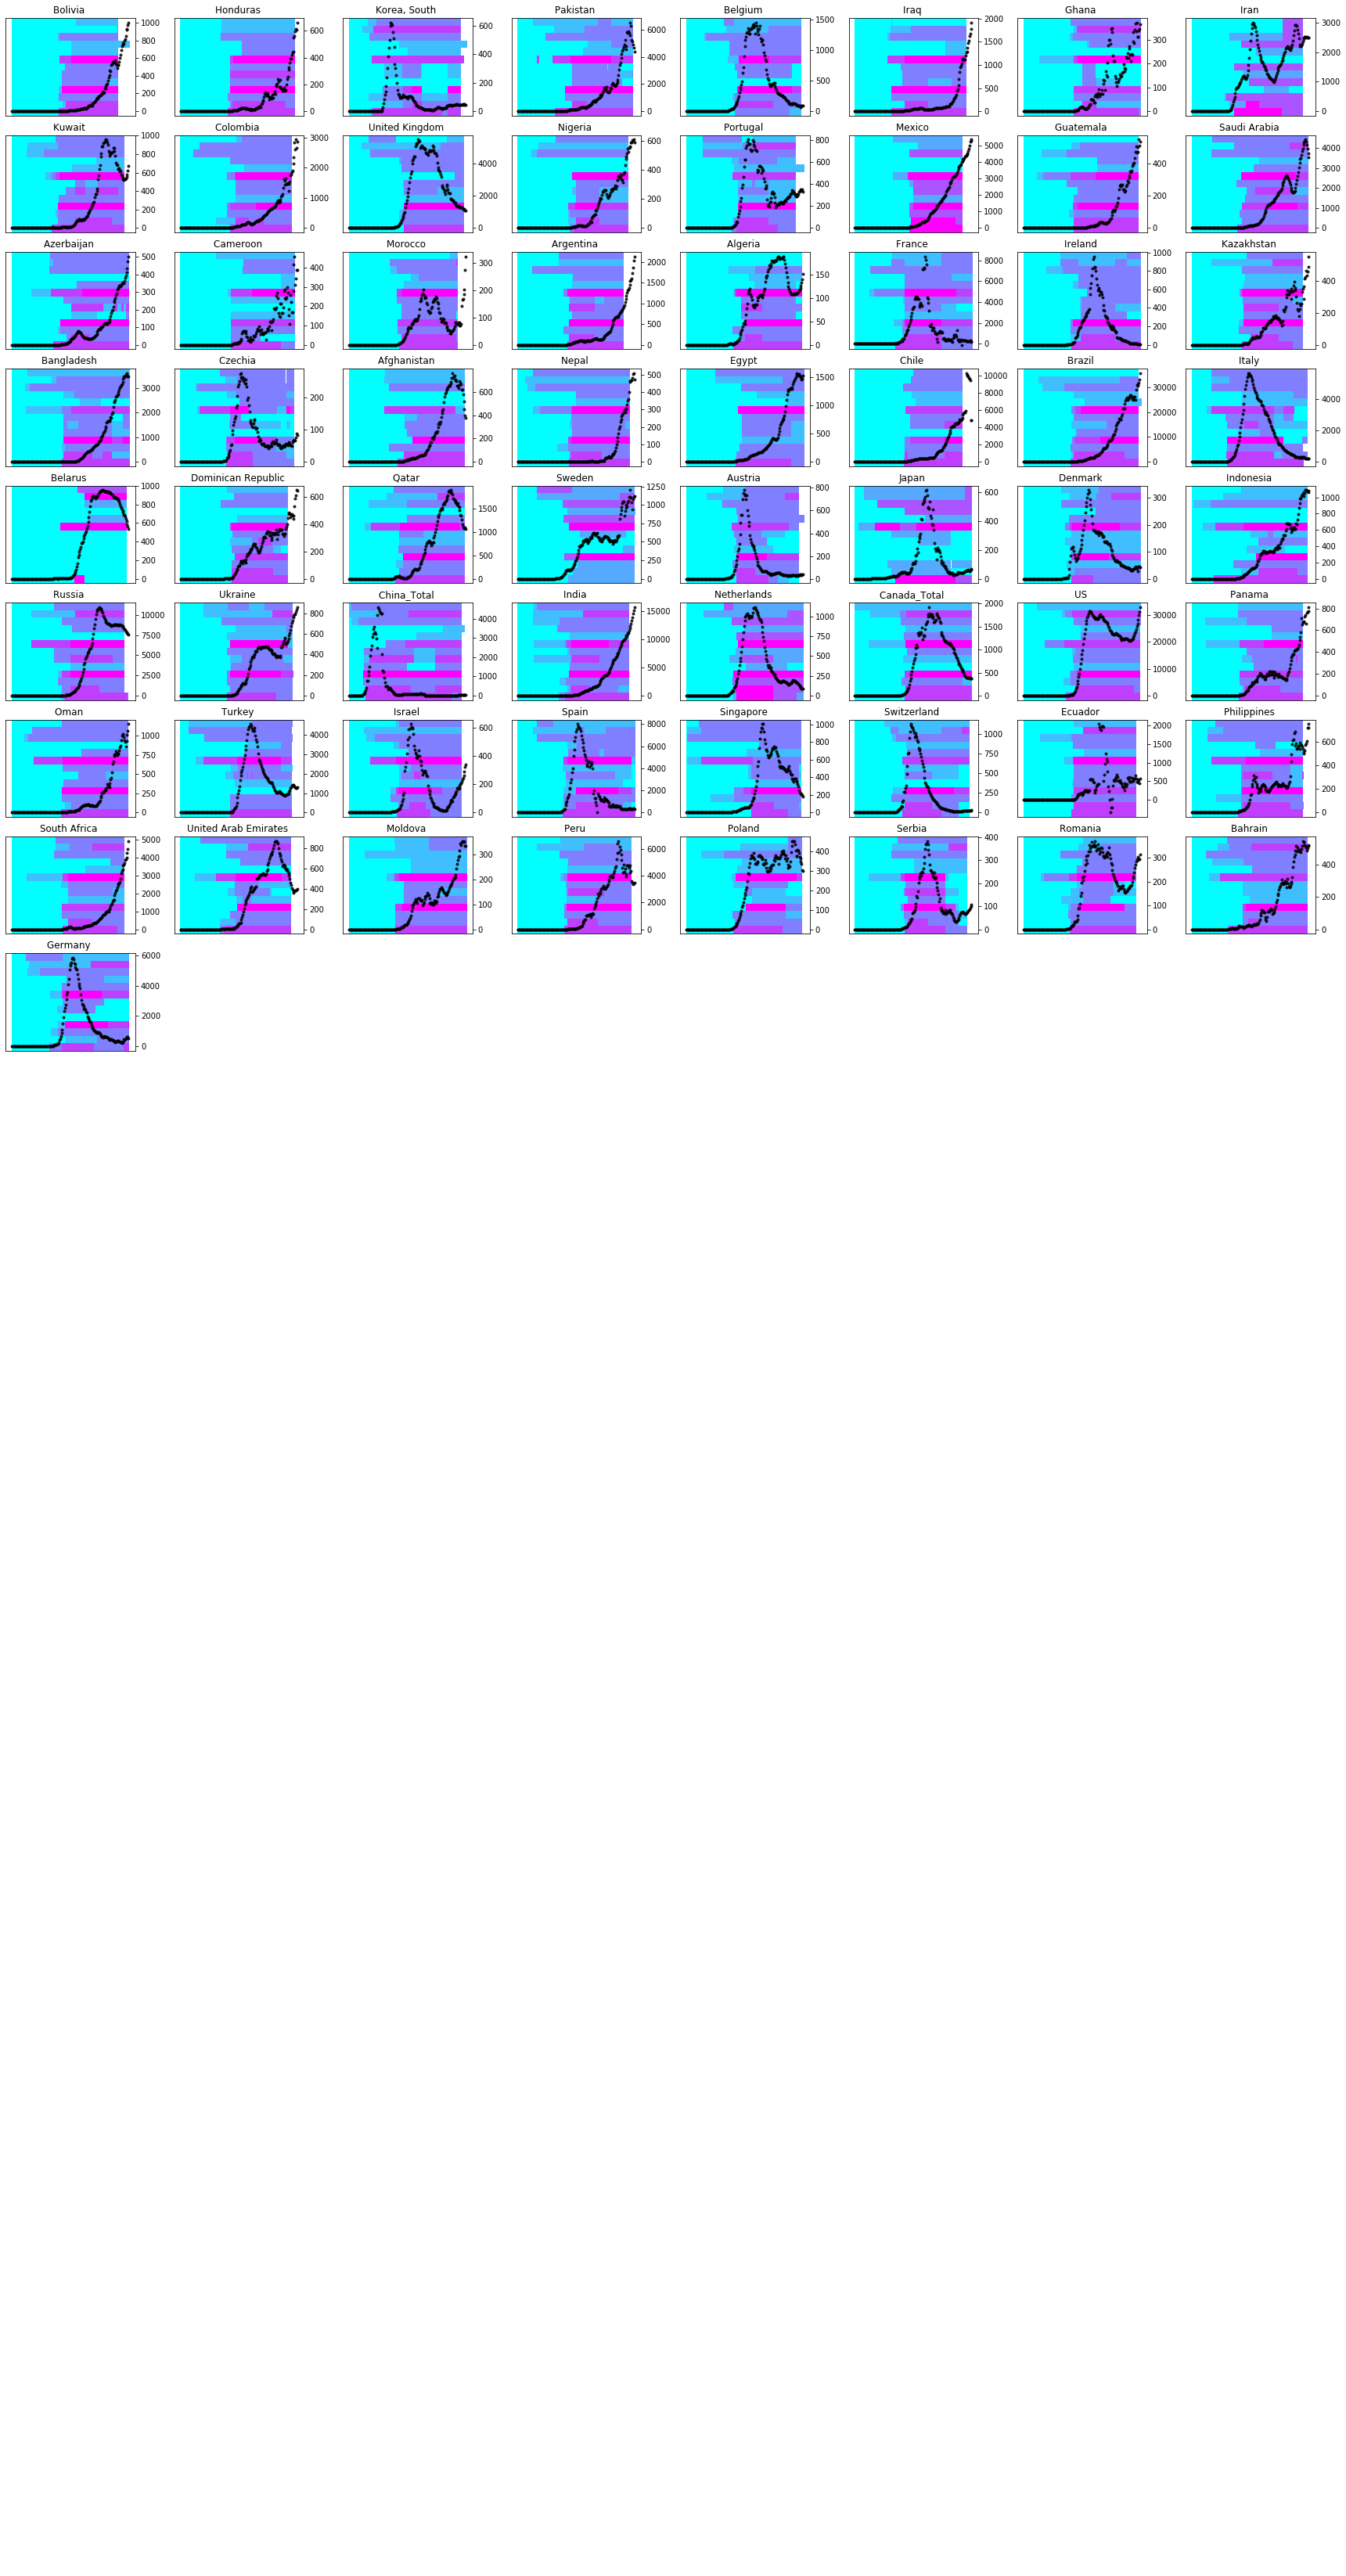

In [69]:
# print country data and corresponding JHU confirmed cases if available on same timescale
print("number of countries",len(countrycodes))
max_rows=22
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(30,60))
for idx, countrycode  in enumerate(countrycodes):
    foo = get_codedat(countrycode)
    # print(np.transpose(foo) # NB need to transpose to get dates on x axis
    foo = [f[1:] for f in foo]
    
    countrynames = [dd['CountryName'] for dd in oxdat if dd['CountryCode']==countrycode]
    countryname = countrynames[0]
    if (countryname,'') not in countries_jhu:
        # print(countryname)
        countryname = country_Oxford_JHU[(countryname,'')]
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#    axes[row, col].imshow(np.transpose(foo),cmap='Accent',aspect='auto',interpolation='none',origin='lower')

    axes[row, col].imshow(np.transpose(foo),cmap='cool',aspect='auto',interpolation='none',origin='lower')

    # axes[row, col].pcolor(np.transpose(foo),cmap='hot')
    # print(countryname)
    # xxx=range(len(np.transpose(foo)[0]))
    axes2=axes[row, col].twinx
    plotCountry(countryname, datatype='confirmed', dataaccum='daily_av_weekly',fittype=None,ax=axes[row,col],ax2=axes2,
                symbol='.',firstdate='01/01/20',lastdate='05/21/20',intdates=True,linecolor='black')

for idx in range(len(countrycodes),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    
plt.subplots_adjust(wspace=.3, hspace=.2)
plt.show()

In [ ]:

# print country data and corresponding JHU confirmed cases if available on same timescale
print("number of countries",len(countrycodes))
max_rows=22
max_cols=8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(30,60))
for idx, countrycode  in enumerate(countrycodes):
    foo = get_codedat(countrycode)
    # print(np.transpose(foo) # NB need to transpose to get dates on x axis
    foo = [f[1:] for f in foo]
    
    countrynames = [dd['CountryName'] for dd in oxdat if dd['CountryCode']==countrycode]
    countryname = countrynames[0]
    if (countryname,'') not in countries_jhu:
        # print(countryname)
        countryname = country_Oxford_JHU[(countryname,'')]
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#    axes[row, col].imshow(np.transpose(foo),cmap='hot',aspect='auto',interpolation='none',origin='lower')
    axes[row, col].imshow(np.transpose(foo),cmap='cool',aspect='auto',interpolation='none',origin='lower')

    # axes[row, col].pcolor(np.transpose(foo),cmap='hot')
    # print(countryname)
    # xxx=range(len(np.transpose(foo)[0]))
    axes2=axes[row, col].twinx
    plotCountry(countryname, datatype='confirmed', fittype=None,ax=axes[row,col],ax2=axes2,
                symbol='.',firstdate='01/01/20',lastdate='05/21/20',intdates=True,linecolor='black')

for idx in range(len(countrycodes),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    
plt.subplots_adjust(wspace=.3, hspace=.2)
plt.show()